# MILESTONE 2

IMDB dataset + Siraj's Network

In [1]:
import numpy as np
import tensorflow as tf

## Preprocessing Dataset

1. Removing punctuations
2. Generating word_to_int map
3. Coverting each review in ints
4. Padding each review with 0's and generating input of length 200

In [2]:
import re
from collections import Counter
from nltk.corpus import stopwords

def preprocess(text):
    
    # Replace punctuation with tokens so we can use them in our model
    '''
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <PERIOD> ')
    text = text.replace('"', ' <PERIOD> ')
    text = text.replace(';', ' <PERIOD> ')
    text = text.replace('!', ' <PERIOD> ')
    text = text.replace('?', ' <PERIOD> ')
    text = text.replace('(', ' <PERIOD> ')
    text = text.replace(')', ' <PERIOD> ')
    text = text.replace('--', ' <PERIOD> ')
    text = text.replace('?', ' <PERIOD> ')
    '''
    text = text.replace('<br />', ' <PERIOD> ')
    text = text.replace('\\', ' <PERIOD> ')
    text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <PERIOD> ')
    text = text.replace(' <PERIOD> ', ' ')
    words = text.split()
    
    return words

def removing_noise(words):
    word_count = Counter(words)
    #stops = set(stopwords.words("english"))
    words_new = [word for word in words if (word_count[word]>5) #and (not word in stops)
                ]
    return words_new
    


In [3]:
import csv

filename = 'data/labeledTrainData.tsv'
review_ids = []
reviews = []
labels = []
#importing dataset into lists
wrong_temp = []
#[92, 102, 120, 259, 404, 1028, 1094, 1184, 1229, 1234, 1343, 1503, 1790, 1861, 2212, 3430, 3771, 3870, 4106, 4407, 4866, 5053, 5218, 5221, 5514, 5553, 5646, 5853, 6086, 6499, 6582, 6746, 7021, 7023, 7194, 7331, 7454, 7473, 7553, 7837, 8119, 8264, 8407, 8433, 8971, 9076, 9204, 9402, 9490, 9552, 9562, 9632, 9716, 9748, 9787, 10107, 10230, 10233, 10414, 10477, 10500, 10702, 10892, 11048, 11055, 11371, 11375, 11513, 11744, 11944, 12071, 12159, 12188, 12243, 12341, 12558, 12594, 12808, 13087, 13159, 14111, 14755, 14860, 14993, 15094, 15260, 15352, 15360, 15656, 15871, 16214, 16274, 16492, 16539, 16613, 16622, 16870, 16949, 16990, 16992, 17071, 17254, 17371, 17450, 17463, 17603, 17709, 17712, 17749, 18024, 18221, 18226, 18681, 18784, 18896, 19063, 19609, 19714, 19889]

with open(filename, 'r') as f:
    next(f)
    reader = csv.reader(f, delimiter='\t')
    row_count = 0
    for row in reader:
        review_ids.append(row[0])
        labels.append([int(row[1])] )
        reviews.append(row[2])

In [4]:
reviews_pp = []
words = []

for review in reviews:
    review_pp = preprocess(review)
    reviews_pp.append(review_pp)
    words.extend(review_pp)
    
words = removing_noise(words)

In [5]:
#Converting word to integers and making the vocabulary
vocab = set(words)
vocab_size = len(vocab)
words_count = Counter(words)
sorted_vocab = sorted(words_count, key = words_count.get, reverse = True)
word_to_int = {word:i for i,word in enumerate(sorted_vocab,1)}

#Converting each review in the form of integers
reviews_pp_ints = []
for review in reviews_pp:
    this_review_int = []
    for word in review:
        if word in vocab:
            this_review_int.append(word_to_int[word])
    reviews_pp_ints.append(this_review_int)

In [6]:
len(reviews_pp_ints[0])

412

In [7]:
len(reviews_pp[0])

429

In [8]:
len(reviews_pp_ints)

25000

In [9]:
max_seq_len = 200
features = np.zeros((len(reviews_pp_ints), max_seq_len), dtype=int)
for i, row in enumerate(reviews_pp_ints):
    features[i, :len(row)] = np.array(row[:max_seq_len] )

In [10]:
# 'features' is a 2d array storing all sequences

## Train Test Validation split

In [11]:
split_frac = 0.8
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

## Building Network

In [12]:
input_size = 300
embed_size = 100
lstm_size = 256
lstm_layers = 1
batch_size = 500
hidden_nodes = 10


X = tf.placeholder(tf.int32, [None, None], name = 'inputs')
Y = tf.placeholder(tf.float32, [None, 1], name = 'labels')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

tf.set_random_seed(5)

embedding = tf.Variable(tf.random_uniform((vocab_size+1, embed_size), -1, 1))
embed = tf.nn.embedding_lookup(embedding, X)

lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)

cell = tf.contrib.rnn.MultiRNNCell([drop]*lstm_layers)

#getting an initial state of zeros\n",
initial_state = cell.zero_state(batch_size, tf.float32)

outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state = initial_state)

#hidden_layer = tf.contrib.layers.fully_connected(outputs[:, -1], hidden_nodes, activation_fn=tf.nn.relu)
predictions = tf.contrib.layers.fully_connected(outputs[:, -1],1, activation_fn=tf.sigmoid)
#predictions,Y\n",

#regularizers =  tf.reduce_mean(tf.nn.l2_loss(tf.trainable_variables() ))
regularizers =sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("noreg" in tf_var.name or "Bias" in tf_var.name))
loss = tf.reduce_mean(tf.square(Y - predictions) )+ 0.01*regularizers
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

In [13]:
#Accuracy:
correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.float32), Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Training

In [14]:
n_epochs = 60

In [15]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
global_train_acc = []
global_test_acc = []

global_train_loss = []
global_test_loss = []
import time
start_time = time.time()
for e in range(n_epochs):
    state = sess.run(initial_state)
    iteration = 1
    loss_=0.0
    temp_train_loss = []
    for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
        feed = {X: x, Y: y, initial_state: state, keep_prob: 0.5}

        state, loss_,  _ = sess.run([final_state, loss, optimizer], feed_dict=feed)

        if iteration%5==0:
            print("Epoch: {}/{}".format(e, n_epochs),
                  "Iteration: {}".format(iteration),
                  "Train loss: {:.5f}".format(loss_))
        temp_train_loss.append(loss_)
        '''
        if iteration%25==0:
            val_acc = []
            val_state = sess.run(cell.zero_state(batch_size, tf.float32))
            for x, y in get_batches(val_x, val_y, batch_size):
                feed = {X: x,
                        Y: y,
                        initial_state: val_state}
                batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                val_acc.append(batch_acc)
            print("Val acc: {:.5f}".format(np.mean(val_acc)))
        '''
        '''
        if iteration%25==0:
            # train Acc calculation
            train_acc = []
            train_state = sess.run(cell.zero_state(batch_size, tf.float32))
            for x, y in get_batches(train_x, train_y, batch_size):
                feed = {X: x,
                        Y: y,
                        initial_state: train_state}
                batch_acc, train_state, corr = sess.run([accuracy, final_state, correct_pred], feed_dict=feed)
                bad_indexes = [index for index, correctness in enumerate(corr) if correctness ==0 ]
                train_acc.append(batch_acc)
            print("Train acc: {:.5f}".format(np.mean(train_acc)))
            global_train_acc.append(np.mean(train_acc))
            
            # test acc calculation
            test_acc = []
            test_state = sess.run(cell.zero_state(batch_size, tf.float32))
            for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
                feed = {X: x,Y: y,initial_state: test_state}

                batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
                test_acc.append(batch_acc)
            print("Train acc: {:.5f}".format(np.mean(test_acc)))
            global_test_acc.append(np.mean(test_acc))
        '''    
        iteration +=1    
    global_train_loss.append(np.mean(temp_train_loss))
    
    temp_test_loss = []
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {X: x,Y: y,initial_state: test_state,  keep_prob: 1}

        batch_acc, test_state, loss_ = sess.run([accuracy, final_state, loss], feed_dict=feed)
        temp_test_loss.append(loss_)
    
    global_test_loss.append(np.mean(temp_test_loss))
    
    
    
print('Training Completed')
print('Total Time Taken: '+str(time.time()-start_time)+' sec' )

Epoch: 0/60 Iteration: 5 Train loss: 6166.73584
Epoch: 0/60 Iteration: 10 Train loss: 5260.27881
Epoch: 0/60 Iteration: 15 Train loss: 4458.91406
Epoch: 0/60 Iteration: 20 Train loss: 3757.53931
Epoch: 0/60 Iteration: 25 Train loss: 3149.47559
Epoch: 0/60 Iteration: 30 Train loss: 2626.40991
Epoch: 0/60 Iteration: 35 Train loss: 2179.65918
Epoch: 0/60 Iteration: 40 Train loss: 1800.54956
Epoch: 1/60 Iteration: 5 Train loss: 1480.68298
Epoch: 1/60 Iteration: 10 Train loss: 1212.23315
Epoch: 1/60 Iteration: 15 Train loss: 988.06384
Epoch: 1/60 Iteration: 20 Train loss: 801.76215
Epoch: 1/60 Iteration: 25 Train loss: 647.65875
Epoch: 1/60 Iteration: 30 Train loss: 520.77972
Epoch: 1/60 Iteration: 35 Train loss: 416.80371
Epoch: 1/60 Iteration: 40 Train loss: 331.99969
Epoch: 2/60 Iteration: 5 Train loss: 263.16507
Epoch: 2/60 Iteration: 10 Train loss: 207.56963
Epoch: 2/60 Iteration: 15 Train loss: 162.89330
Epoch: 2/60 Iteration: 20 Train loss: 127.17708
Epoch: 2/60 Iteration: 25 Train l

Epoch: 22/60 Iteration: 5 Train loss: 0.24991
Epoch: 22/60 Iteration: 10 Train loss: 0.25004
Epoch: 22/60 Iteration: 15 Train loss: 0.24999
Epoch: 22/60 Iteration: 20 Train loss: 0.25007
Epoch: 22/60 Iteration: 25 Train loss: 0.25010
Epoch: 22/60 Iteration: 30 Train loss: 0.25024
Epoch: 22/60 Iteration: 35 Train loss: 0.25003
Epoch: 22/60 Iteration: 40 Train loss: 0.25006
Epoch: 23/60 Iteration: 5 Train loss: 0.24991
Epoch: 23/60 Iteration: 10 Train loss: 0.25004
Epoch: 23/60 Iteration: 15 Train loss: 0.24999
Epoch: 23/60 Iteration: 20 Train loss: 0.25007
Epoch: 23/60 Iteration: 25 Train loss: 0.25010
Epoch: 23/60 Iteration: 30 Train loss: 0.25024
Epoch: 23/60 Iteration: 35 Train loss: 0.25003
Epoch: 23/60 Iteration: 40 Train loss: 0.25006
Epoch: 24/60 Iteration: 5 Train loss: 0.24991
Epoch: 24/60 Iteration: 10 Train loss: 0.25004
Epoch: 24/60 Iteration: 15 Train loss: 0.24999
Epoch: 24/60 Iteration: 20 Train loss: 0.25007
Epoch: 24/60 Iteration: 25 Train loss: 0.25010
Epoch: 24/60 Ite

Epoch: 43/60 Iteration: 40 Train loss: 0.25008
Epoch: 44/60 Iteration: 5 Train loss: 0.24994
Epoch: 44/60 Iteration: 10 Train loss: 0.25007
Epoch: 44/60 Iteration: 15 Train loss: 0.25001
Epoch: 44/60 Iteration: 20 Train loss: 0.25010
Epoch: 44/60 Iteration: 25 Train loss: 0.25013
Epoch: 44/60 Iteration: 30 Train loss: 0.25027
Epoch: 44/60 Iteration: 35 Train loss: 0.25005
Epoch: 44/60 Iteration: 40 Train loss: 0.25008
Epoch: 45/60 Iteration: 5 Train loss: 0.24994
Epoch: 45/60 Iteration: 10 Train loss: 0.25007
Epoch: 45/60 Iteration: 15 Train loss: 0.25002
Epoch: 45/60 Iteration: 20 Train loss: 0.25010
Epoch: 45/60 Iteration: 25 Train loss: 0.25013
Epoch: 45/60 Iteration: 30 Train loss: 0.25027
Epoch: 45/60 Iteration: 35 Train loss: 0.25006
Epoch: 45/60 Iteration: 40 Train loss: 0.25009
Epoch: 46/60 Iteration: 5 Train loss: 0.24994
Epoch: 46/60 Iteration: 10 Train loss: 0.25007
Epoch: 46/60 Iteration: 15 Train loss: 0.25002
Epoch: 46/60 Iteration: 20 Train loss: 0.25010
Epoch: 46/60 Ite

In [17]:
test_acc = []
test_state = sess.run(cell.zero_state(batch_size, tf.float32))
for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
    feed = {X: x,Y: y,initial_state: test_state, keep_prob: 1}

    batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
    test_acc.append(batch_acc)
print("Train acc: {:.5f}".format(np.mean(test_acc)))

Train acc: 0.49840


In [18]:
'''
wrong_temp = [92, 282, 1184, 2331, 2815, 2848, 3233, 4833, 7077, 7713, 7837, 8724, 9364, 10162, 10477, 12243, 14445, 15076, 18896, 19741, 19895]
for i in wrong_temp[:]:
    print('#'+str(i))
    print(reviews[i])
    print('-->Label='+str(labels[i]))
    print()
    print()
'''

#92
Okay, first of all I got this movie as a Christmas present so it was FREE! FIRST - This movie was meant to be in stereoscopic 3D. It is for the most part, but whenever the main character is in her car the movie falls flat to 2D! What!!?!?! It's not that hard to film in a car!!! SECOND - The story isn't very good. There are a lot of things wrong with it.<br /><br />THIRD - Why are they showing all of the deaths in the beginning of the film! It made the movie suck whenever some was going to get killed!!! Watch it for a good laugh , but don't waste your time buying it. Just download it or something for cheap.
-->Label=[1]


#282
When I heard Patrick Swayze was finally returning to his acting career with KING SOLOMON'S MINES I was very excited. I was expecting a great Indiana Jones type action adventure. What I got was a 4 hour long (with commercials) epic that was very slow. The second and third hour could have been dropped altogether and the story would not have suffered for it. The 

In [19]:
'''
max_l = 0
min_l = 10000
i = 0
m = -1
for review in reviews_pp_ints:

    if len(review) > max_l:
        max_l = len(review)
    if len(review) < min_l:
        min_l = len(review)
        m = i
    i += 1
reviews[m], m, labels[m]
'''

('Ming The Merciless does a little Bardwork and a movie most foul!',
 22258,
 [0])

In [20]:
words_count['terrible']

1005

In [21]:
words_count['horror']

2715

In [22]:
a = [92, 282, 1184, 2331, 2815, 2848, 3233, 4833, 7077, 7713, 7837, 8724, 9364, 10162, 10477, 12243, 14445, 15076, 18896, 19741, 19895]
len(a)

21

## Scores of Bad Indices

In [23]:
'''
for index in a:
    state = sess.run(initial_state)

    feed = {X: features[index].reshape(1,None) , Y: labels[index].reshape(1,None), initial_state: state}

        outputs_ = sess.run([outputs], feed_dict=feed)

    print("Index:() ".format(index))
    print("Prediction:{} ".format(outputs_))
'''

'\nfor index in a:\n    state = sess.run(initial_state)\n\n    feed = {X: features[index].reshape(1,None) , Y: labels[index].reshape(1,None), initial_state: state}\n\n        outputs_ = sess.run([outputs], feed_dict=feed)\n\n    print("Index:() ".format(index))\n    print("Prediction:{} ".format(outputs_))\n'

## Training - Test Curve

In [24]:
print(len(global_train_loss))
print(global_test_loss)

60
[1732.097, 317.04868, 42.455299, 4.1286335, 0.48109666, 0.25812858, 0.25018141, 0.25004876, 0.25004956, 0.25005072, 0.25005177, 0.25005269, 0.25005347, 0.25005412, 0.25005472, 0.25005531, 0.25005573, 0.25005618, 0.25005656, 0.25005698, 0.25005731, 0.25005752, 0.25005788, 0.25005865, 0.25005871, 0.25005895, 0.25005931, 0.25005931, 0.2500602, 0.25005993, 0.25006109, 0.25006181, 0.25006664, 0.25010651, 0.25009227, 0.25008768, 0.25008756, 0.25008753, 0.25008968, 0.25008476, 0.25008541, 0.25008583, 0.25008672, 0.25008559, 0.25008792, 0.25008759, 0.25008926, 0.2500917, 0.25010484, 0.25007907, 0.25007856, 0.25007993, 0.25007945, 0.25010499, 0.25018105, 0.25013834, 0.25014001, 0.25011641, 0.2501058, 0.25010327]


In [25]:
'''
for i in range( len(global_train_acc) ):
    global_train_acc[i] /=100
    global_test_acc[i] /=100
'''    

[3936.8328, 870.70801, 143.63805, 17.285648, 1.6351658, 0.32228947, 0.25223947, 0.25010854, 0.25008121, 0.25008264, 0.25008392, 0.25008497, 0.25008592, 0.25008669, 0.25008741, 0.25008801, 0.2500886, 0.25008905, 0.2500895, 0.25008991, 0.25009021, 0.25009051, 0.25009093, 0.25009137, 0.2500917, 0.25009209, 0.25009218, 0.2500926, 0.25009292, 0.25009322, 0.25009361, 0.25009465, 0.2500965, 0.25014892, 0.25012994, 0.2501238, 0.25011995, 0.25012091, 0.2501213, 0.25011975, 0.25011784, 0.25011891, 0.25011975, 0.25011966, 0.25011978, 0.25012127, 0.25012192, 0.25012341, 0.25012764, 0.2501173, 0.2501114, 0.25011206, 0.25011224, 0.25011575, 0.25018805, 0.2501896, 0.25018039, 0.25015876, 0.25014466, 0.25013864]
[1732.097, 317.04868, 42.455299, 4.1286335, 0.48109666, 0.25812858, 0.25018141, 0.25004876, 0.25004956, 0.25005072, 0.25005177, 0.25005269, 0.25005347, 0.25005412, 0.25005472, 0.25005531, 0.25005573, 0.25005618, 0.25005656, 0.25005698, 0.25005731, 0.25005752, 0.25005788, 0.25005865, 0.25005871

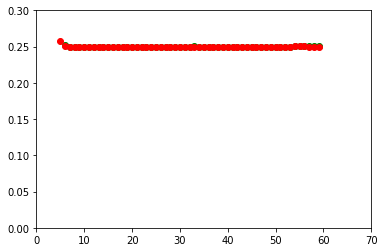

Minimum Testing Loss: 0.250049


In [26]:
print(global_train_loss)
print(global_test_loss)
import matplotlib.pyplot as plt
%matplotlib inline 
plt.ion()
x = range(60) 
plt.axis([0,70,0,0.3])
plt.plot(x,global_train_loss,'go',x,global_test_loss,'ro')
plt.show()

print('Minimum Testing Loss: '+str(np.min(global_test_loss)) )

In [27]:
print(reviews[92])

Okay, first of all I got this movie as a Christmas present so it was FREE! FIRST - This movie was meant to be in stereoscopic 3D. It is for the most part, but whenever the main character is in her car the movie falls flat to 2D! What!!?!?! It's not that hard to film in a car!!! SECOND - The story isn't very good. There are a lot of things wrong with it.<br /><br />THIRD - Why are they showing all of the deaths in the beginning of the film! It made the movie suck whenever some was going to get killed!!! Watch it for a good laugh , but don't waste your time buying it. Just download it or something for cheap.
